## Set up

In [23]:
from google.cloud import aiplatform
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'koa-biotech'

In [4]:
REGION = 'europe-west1'
model_id = '2745229845905539072'

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION)

In [6]:
model = aiplatform.Model(model_name=f"projects/{PROJECT_ID}/locations/{REGION}/models/{model_id}")

## Model Evaluation

### Confusion Matrix

In [7]:
model_evaluations = model.list_model_evaluations()

In [8]:
evaluation = model_evaluations[0].to_dict()

In [81]:
l = len(evaluation.get('metrics').get('confidenceMetrics'))
em = evaluation.get('metrics').get('confidenceMetrics')[l//2]

In [10]:
cm = em.get('confusionMatrix')

In [11]:
cm_rows = list(cm.get('rows'))[:-1]
anot = cm.get('annotationSpecs')
labels = [val['displayName'] for val in anot]
cm_df = pd.DataFrame(cm_rows,
                     columns=labels,
                     index=labels[:-1])
cm_df.columns = pd.MultiIndex.from_product([['predicted'], cm_df.columns])
cm_df.index = pd.MultiIndex.from_product([['actual'], cm_df.index])

cm_df

predicted                                         \
                    vharveyi control ahydrophila vangil pdpiscicida   
actual vharveyi         34.0     2.0         2.0    0.0         0.0   
       control           6.0    28.0         0.0    0.0         0.0   
       ahydrophila       2.0     2.0        22.0    2.0         0.0   
       vangil            2.0     0.0         0.0    6.0         0.0   
       pdpiscicida       0.0     0.0         0.0    2.0        10.0   
       tmaritimum        0.0     0.0         0.0    0.0         2.0   

                                       
                   tmaritimum DROPPED  
actual vharveyi           2.0     2.0  
       control            0.0     0.0  
       ahydrophila        0.0     0.0  
       vangil             0.0     0.0  
       pdpiscicida        0.0     4.0  
       tmaritimum         2.0     4.0

### Metrics

In [21]:
# Overall accuracy
n = cm_df.sum().sum()
TP = 0
for label in labels[:-1]:
    TP += cm_df.loc[[('actual', label)]][('predicted', label)].sum()
acc = 100*TP/n 
acc

75.0

In [55]:
# Precisions
precisions = []
for label in labels[:-1]:
    p = cm_df.loc[('actual', label), ('predicted', label)].sum() / cm_df.loc[:, ('predicted', label)].sum() * 100
    precisions.append(p)
precisions

[77.27272727272727, 87.5, 91.66666666666666, 60.0, 83.33333333333334, 50.0]

In [57]:
# Fallouts
fallouts = []
for label in labels[:-1]:
    f = cm_df.loc[cm_df.index.get_level_values(1) != label].loc[:, ('predicted', label)].sum() / cm_df.loc[cm_df.index.get_level_values(1) != label].sum().sum() * 100
    fallouts.append(f)
fallouts

[10.638297872340425,
 3.9215686274509802,
 1.8518518518518516,
 3.125,
 1.6666666666666667,
 1.5625]

In [27]:
# Recalls
recalls = []
for label in labels[:-1]:
    r = cm_df.loc[('actual', label), ('predicted', label)].sum() / cm_df.loc[('actual', label), :].sum() * 100
    recalls.append(r)
recalls

[80.95238095238095, 82.35294117647058, 78.57142857142857, 75.0, 62.5, 25.0]

In [68]:
# False Omission Rates
fors = []
for label in labels[:-1]:
    f = cm_df.loc[:, cm_df.columns.get_level_values(1) != label].loc[('actual', label), :].sum() / cm_df.loc[:, cm_df.columns.get_level_values(1) != label].sum().sum() * 100
    fors.append(f)
fors

[8.695652173913043,
 5.769230769230769,
 5.357142857142857,
 1.5873015873015872,
 4.838709677419355,
 4.545454545454546]

### Insights

In [31]:
for a in zip(range(1,len(labels)), labels[:-1]):
    print(a[0],'-',a[1])

1 - vharveyi
2 - control
3 - ahydrophila
4 - vangil
5 - pdpiscicida
6 - tmaritimum


In [77]:
# Select pathogen
## USER INPUT ##
selection = 4

###
pathogen = labels[selection - 1]
recall = recalls[selection-1]
fallout = fallouts[selection-1]
precision = precisions[selection-1]
_for = fors[selection-1]

In [74]:
print(f'The overall model accuracy is {acc:.2f}%')

The overall model accuracy is 75.00%


In [80]:
print(f'Given that there is {pathogen} in the sample, the model is {recall:.2f}% likely to detect it.')
print(f'Given that there is no {pathogen} in the sample, the model is {fallout:.2f}% likely to wrongly detect it.')

Given that there is vangil in the sample, the model is 75.00% likely to detect it.
Given that there is no vangil in the sample, the model is 3.12% likely to wrongly detect it.


In [79]:
print(f'Given that the model detected {pathogen}, the sample is {precision:.2f}% likely to have a {pathogen}.')
print(f'Given that the model did not detect {pathogen}, the sample is still {_for:.2f}% likely to have {pathogen}.')

Given that the model detected vangil, the sample is 60.00% likely to have a vangil.
Given that the model did not detect vangil, the sample is still 1.59% likely to have vangil.


## Feature Importances

In [71]:
explanation = evaluation.get('modelExplanation')

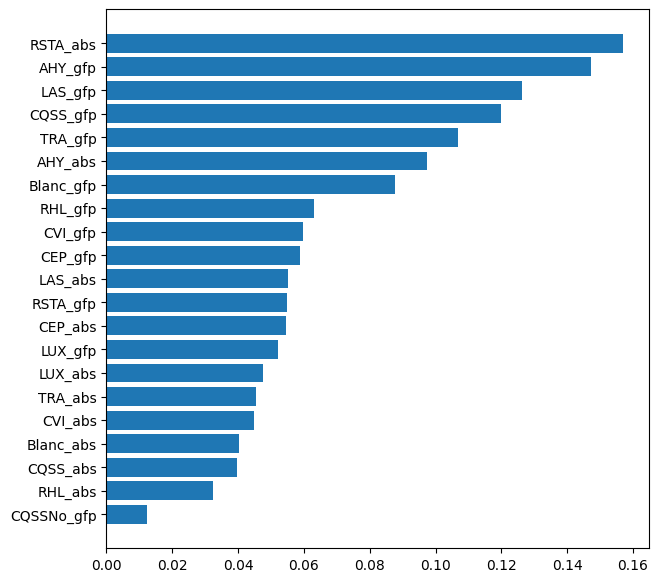

In [72]:
features = []
scores = []
for k in explanation.get('meanAttributions')[0].get('featureAttributions'):
    features.append(k)
    scores.append(explanation.get('meanAttributions')[0].get('featureAttributions')[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.barh(features, scores)
fig.show()